# Null hypothesis: There is no difference in similarities of documents analyzed through by Doc2Vec and Word2Vec

# Alternate hypothesis: There are differences in similarities of documents  analyzed through Doc2Vec and Word2Vec

In [129]:
import pandas as pd

In [130]:
from gensim.models import doc2vec
from gensim.models import word2vec

In [131]:
def label_sentence(sentence, label):
    return doc2vec.LabeledSentence(words=sentence, tags=[label])

In [132]:
df = pd.read_csv("./billboard.csv",encoding="latin")

In [133]:
df = df.dropna()
df = df[df['Lyrics']!="instrumental"]

In [134]:
df.drop('Rank',axis=1)
df = df.reset_index(drop=True)

In [135]:
song_id=1313
song_name = df.iloc[song_id]['Song']+" - "+df.iloc[song_id]['Artist']
print(song_name)

i will survive - gloria gaynor


# Preparing Labelled Sentences for training Doc2Vec

In [136]:
docs = []
for i in range(len(df)):
    row = df.iloc[i]
    lyrics = row['Lyrics']
    if(lyrics != "instrumental"):
        docs.append(label_sentence(lyrics,str(i)))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  


# Training Doc2Vec and Word2Vec on same set of Lyrics (Billboard songs 1965 - 2015)

In [137]:
d2v = doc2vec.Doc2Vec(docs, size=300, window=8, min_count=5, workers=4)
w2v = word2vec.Word2Vec(df['Lyrics'].apply(lambda x:x.split(" ")), size=300, window= 8, min_count=5,workers=4)

/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [138]:
d2v_sim = [None]*len(df)
for i,d in d2v.docvecs.most_similar(str(song_id),topn=len(df)):
    d2v_sim[int(i)] = d

# Adding Doc2Vec similarity of {{song_name}} lyrics to lyrics of all other songs to data frame column 

In [139]:
df['d2v_similarity']=d2v_sim

In [140]:
import numpy as np

def normalize(word_vec):
    norm=np.linalg.norm(word_vec)
    if norm == 0: 
       return word_vec
    return word_vec/norm
def getWord2VecSentenceVector(sentence):
    sentence = sentence.split(" ")
    vector = None
    i = 0
    for word in sentence:
        try:
            v = w2v[word]
            if(vector is None):
                vector = v
                i+=1
            else:
                vector =vector+v
        except:
            continue
    vector /= i
    return normalize(vector)

# Adding Word2Vec similarity of {{song_name}} lyrics to lyrics of all other songs to data frame column 

In [141]:
df['w2v_vector'] = df['Lyrics'].apply(getWord2VecSentenceVector)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [142]:
from scipy.spatial.distance import cosine
rick_roll = getWord2VecSentenceVector(df.iloc[song_id]['Lyrics'])
df['w2v_similarity'] = df['w2v_vector'].apply(lambda x:cosine(x,rick_roll))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [143]:
import matplotlib.pyplot as plt

Text(0.5,1,'Year vs Difference in Similarity between W2V and D2V')

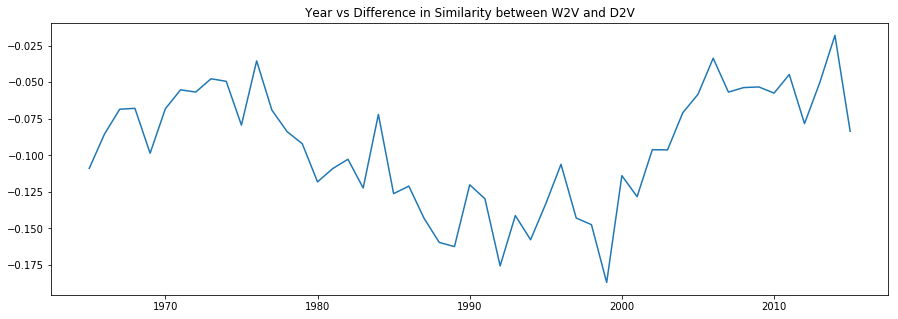

In [144]:
plt.figure(figsize=(15,5))
plt.plot(df.groupby("Year").mean().index,df.groupby("Year").mean()['w2v_similarity']-df.groupby("Year").mean()['d2v_similarity'])
plt.title("Year vs Difference in Similarity between W2V and D2V")

Text(0.5,0,'Year')

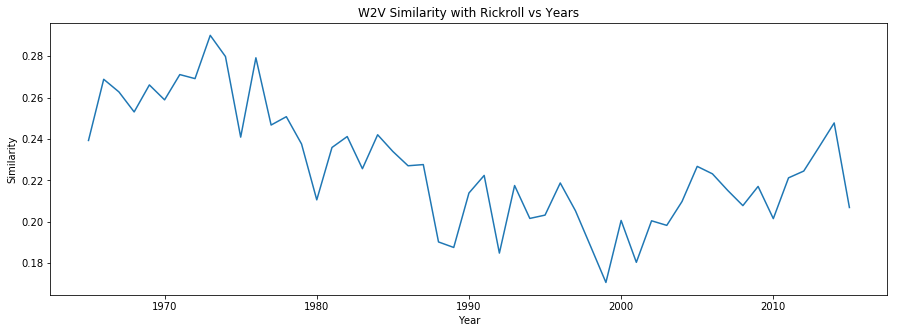

In [213]:
plt.figure(figsize=(15,5))
plt.plot(df.groupby("Year").mean()['w2v_similarity'])
plt.title("W2V Similarity with Rickroll vs Years")
plt.ylabel("Similarity")
plt.xlabel("Year")

Text(0.5,0,'Year')

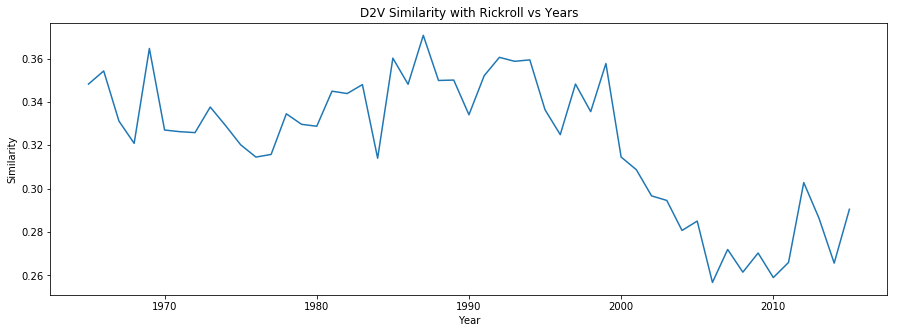

In [146]:
plt.figure(figsize=(15,5))
plt.plot(df.groupby("Year").mean()['d2v_similarity'])
plt.title("D2V Similarity with Rickroll vs Years")
plt.ylabel("Similarity")
plt.xlabel("Year")

# Finding number of songs where Doc2Vec and Word2Vec share cosine similarity within 10% range

In [147]:
num_similar_songs = len([x for x in (df['d2v_similarity']-df['w2v_similarity']).apply(lambda x:abs(x)) if x <= 0.1])

In [148]:
total_num_songs = len(df)

In [149]:
num_similar_songs/total_num_songs

0.22886892609228257

In [150]:
from annoy import AnnoyIndex

In [151]:
w2v_cluster = AnnoyIndex(300,metric='angular')

In [152]:
for i in range(len(df)):
    row = df.iloc[i]
    vector = row['w2v_vector']
    w2v_cluster.add_item(i,vector)

In [153]:
w2v_cluster.build(100)

True

# showing top 10 most similar songs to {{song_name}} using Word2Vec

In [154]:
for i in w2v_cluster.get_nns_by_vector(rick_roll,10):
    print(df.iloc[i]['Song'])
    print()
    print(df.iloc[i]['Lyrics'])
    print()

i will survive

 at first i was afraid i was petrified thinking i couldnt live without you by my side and ive been spending nights thinking how you did me wrong and i grew strong and i learned how to get along and now youre back from outer space and i find you here with that sad look upon your face i should have changed that stupid lock oh made you leave your key if ive known for a second youd be back to bother me go on now go walk out the door turn around now youre not welcome anymore youre the one who tried to hurt me with goodbye do you think id crumble did you think id lay down and dieno not i i will survive long as i know how to love i know ill stay alive ive got all my life to live and all my love to give and ill survive i i i will surviveit took all my strength not to fall apart trying without my mind to mend my broken heart i spent so many nights feeling sorry for myself how i cried but now i hold my head up high and you see me somebody new im not that lonely little person whos

# showing top 10 most similar songs to {{song_name}} using Doc2Vec

In [155]:
for i,d in d2v.docvecs.most_similar(str(song_id),topn=10):
    print(df.iloc[int(i)]['Song'])
    print()
    print(df.iloc[int(i)]['Lyrics'])
    print()

all i have to give

 i dont know what he does to make you cry but ill be there to make you smile i dont have a fancy car to get to you id walk a thousand miles i dont care if he buys you nice things does his gifts come from the heart i dont know but if you were my girl id make it so wed never be apartbut my love is all i have to give without you i dont think i can live i wish i could give the world to you but love is all i have to givewhen you talk does it seem like hes not even listening to a word you say thats okay babe just tell me your problems ill try my best to kiss them all away does he leave when you need him the most does his friends get all your time baby please im on my knees praying for the day that youll be minebut my love is all i have to give without you i dont think i can live i wish i could give the world to you but love is all i have to giveto you hey girl hey girl i dont want you to cry no more inside all the money in the world could never add up to all the love i ha

# Use chi-square test to show that the difference between Doc2Vec and Word2Vec are not the same

In [156]:
from scipy.stats import chisquare

In [157]:
df2 = df.dropna()

In [158]:
chisquare(f_obs=df2['d2v_similarity'],f_exp=df2['w2v_similarity'],ddof=len(df2)-1)

Power_divergenceResult(statistic=3140.8421539750702, pvalue=nan)

In [159]:
len(df2)

4897

In [160]:
df2['d2v_similarity'] = df2['d2v_similarity'].apply(lambda x:round(x,1))
df2['w2v_similarity'] = df2['w2v_similarity'].apply(lambda x:round(x,1))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Doc2Vec Similarity Frequency Distribution

Text(0,0.5,'Frequency')

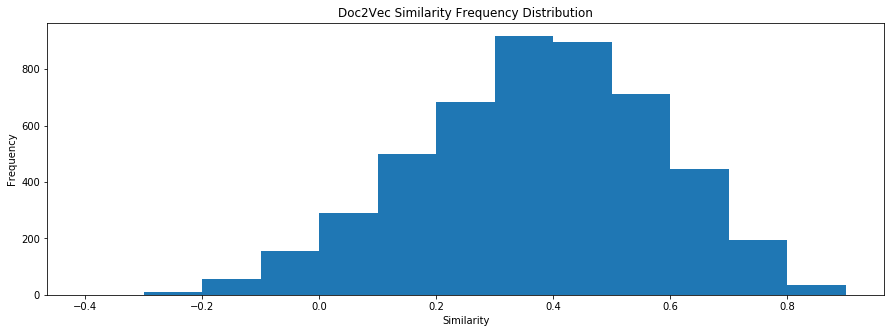

In [210]:
plt.figure(figsize=(15,5))
plt.hist(df2['d2v_similarity'],df2.groupby('d2v_similarity').count()['Rank'].index)
plt.title("Doc2Vec Similarity Frequency Distribution")
plt.xlabel("Similarity")
plt.ylabel("Frequency")

# Word2Vec Similarity Frequency Distribution

Text(0,0.5,'Frequency')

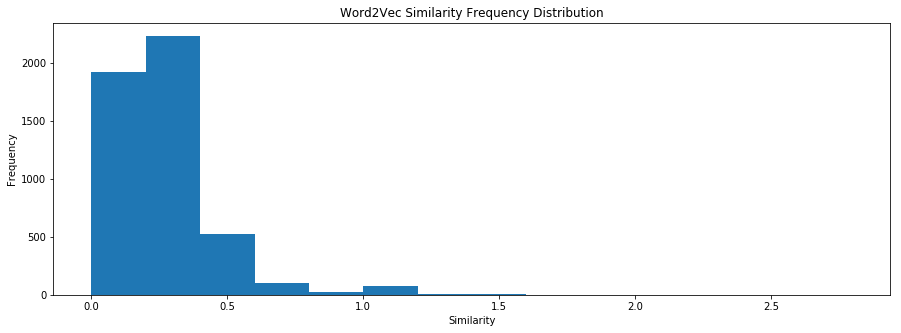

In [214]:
plt.figure(figsize=(15,5))
plt.hist(df2['w2v_similarity'],df2.groupby('w2v_similarity').count()['Rank'].index)
plt.title("Word2Vec Similarity Frequency Distribution")
plt.xlabel("Similarity")
plt.ylabel("Frequency")

# Word2Vec Mean Median Mode Std.deviation

In [163]:
print(df2['w2v_similarity'].mean())
print(df2['w2v_similarity'].median())
print(df2['w2v_similarity'].mode())
print(df2['w2v_similarity'].std())

0.22752705738207818
0.2
0    0.1
dtype: float64
0.17346982316117554


# Doc2Vec Mean Median Mode Std.deviation

In [164]:
print(df2['d2v_similarity'].mean())
print(df2['d2v_similarity'].median())
print(df2['d2v_similarity'].mode())
print(df2['d2v_similarity'].std())

0.32191137431080213
0.3
0    0.3
dtype: float64
0.20750763310653633


In [165]:
from scipy.stats.mstats import normaltest

## Normality Test rejects null hypothesis that W2V is normally distributed

In [166]:
normaltest(df2['w2v_similarity'])

NormaltestResult(statistic=2797.958243224847, pvalue=0.0)

## Normality Test rejects null hypothesis that D2V is normally distributed

In [167]:
normaltest(df2['d2v_similarity'])

NormaltestResult(statistic=71.14217197263038, pvalue=3.5618337180453454e-16)

# Finding lyrics with greatest difference in similarity results produced by Doc2Vec and Word2Vec

In [168]:
df3 = df
df3['x'] = abs(df['d2v_similarity']-df['w2v_similarity'])

In [169]:
df3.nlargest(10,'x')

,Rank,Song,Artist,Year,Lyrics,Source,d2v_similarity,w2v_vector,w2v_similarity,x
3882,60,la tortura,shakira featuring alejandro sanz,2005,ay padrita mÌ_a guÌÁrdate la poesÌ_a guÌÁrdat...,1.0,-0.317299,"[0.029544478, -0.046306677, 0.09437567, 0.0933...",1.359021,1.676320
4894,96,el perdon,nicky jam and enrique iglesias,2015,enrique iglesias dime si es verdad me dijeron ...,3.0,-0.329282,"[0.015417236, -0.012782908, 0.09188404, 0.0897...",1.290817,1.620100
2957,1,macarena bayside boys mix,los del r'io,1996,dale a tu cuerpo alegria macarena que tu cuer...,1.0,-0.150240,"[0.047956422, -0.0678671, 0.062467128, 0.12127...",1.418623,1.568863
3044,98,macarena,los del r'io,1996,dale a tu cuerpo alegria macarena que tu cuer...,1.0,-0.119493,"[0.047956422, -0.0678671, 0.062467128, 0.12127...",1.418623,1.538116
3122,82,macarena bayside boys mix,los del r'io,1997,dale a tu cuerpo alegria macarena que tu cuer...,1.0,-0.061894,"[0.047956422, -0.0678671, 0.062467128, 0.12127...",1.418623,1.480516
4738,38,bailando,enrique iglesias featuring descemer bueno and ...,2014,yo te miro se me corta la respiraciÌ_n cuanto...,1.0,-0.215929,"[0.017414687, -0.0046188235, 0.08088088, 0.092...",1.223450,1.439380
654,100,somos novios its impossible,perry como,1971,feat christina aguileraandrea somos novios pu...,1.0,-0.054958,"[0.0332309, -0.07186207, 0.06267809, 0.1415184...",1.378191,1.433149
2085,11,la bamba,los lobos,1987,para bailar la bamba para bailar la bamba se ...,1.0,0.001096,"[0.02388951, -0.066721246, 0.09147538, 0.16289...",1.406564,1.405468
173,83,guantanamera,the sandpipers,1966,guantanamera guajira guantanamera guantanamer...,1.0,0.067771,"[0.027149564, -0.07011403, 0.090014845, 0.1365...",1.402113,1.334342
810,69,hocus pocus,focus,1973,Ì«i orÌ«rÌ«i rÌ«rÌ«rÌ«i rÌ«rÌ«rÌ«i rÌ«rÌ«rÌ«i ...,3.0,0.016090,"[0.023343429, -0.047198303, 0.10224481, 0.1838...",1.332735,1.316645


In [170]:
print(df.iloc[2178].Lyrics[:200],"...")
print('------------------------------------------------------------')
print(df.iloc[4894].Lyrics[:200],"...")
print()
print(df.iloc[2957].Lyrics[:200],"...")
print()
print(df.iloc[4548].Lyrics[:200],"...")
print()
print(df.iloc[3882].Lyrics[:200],"...")
print()
print(df.iloc[2085].Lyrics[:200],"...")

 ooh oohwere no strangers to love you know the rules and so do i a full commitments what im thinking of you wouldnt get this from any other guy i just wanna tell you how im feeling gotta make you unde ...
------------------------------------------------------------
enrique iglesias dime si es verdad me dijeron que te estas casando tÌ¼ no sabes lo estoy sufriendo esto te lo tengo que decir nicky jam cuÌ©ntame tu despedida para mi fue dura serÌÁ que te llevo a la  ...

 dale a tu cuerpo alegria macarena que tu cuerpo es pa darle alegria y cosa buena dale a tu cuerpo alegria macarena hey macarenadale a tu cuerpo alegria macarena que tu cuerpo es pa darle alegria y co ...

 rack rack city bitch rack rack rack city bitch rack rack rack rack city bitch mustard on the beat horack city bitch rack rack city bitch ten ten ten twenty on yo titties bitch 100 deep vip no guest l ...

 ay padrita mÌ_a guÌÁrdate la poesÌ_a guÌÁrdate la alegrÌ_a pa tidame dame dÌÁmelo ohno pido que todos los dÌ_as sea